# 1. 라이브러리 임포트

In [ ]:
from google.colab import drive
import pandas as pd
import numpy as np

import json
import os
from statistics import median

from PIL import Image, ImageOps, ImageDraw
import cv2

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns

from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications import ResNet50V2, ResNet101V2, ResNet152V2, ConvNeXtTiny, ConvNeXtSmall, ConvNeXtBase
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, LayerNormalization, Dense

import warnings
warnings.filterwarnings(action='ignore')

In [ ]:
!pip install koreanize-matplotlib
import koreanize_matplotlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 34.0 MB/s eta 0:00:00


In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


# 2. 데이터 불러오기 및 데이터프레임 생성하기

In [ ]:
# json path 생성
label_path = '/content/drive/MyDrive/Data/label'
train_label_path = os.path.join(label_path, 'train')
val_label_path = os.path.join(label_path, 'val')
label_json_list = ['anger.json', 'happy.json', 'panic.json', 'sadness.json']

# image path 생성
image_path = '/content/drive/MyDrive/preprocessed_crop'
train_path = os.path.join(image_path,'train')
val_path = os.path.join(image_path,'val')

# segmentation path 생성
seg_path = '/content/drive/MyDrive/preprocessed_seg'
train_seg_path = os.path.join(seg_path,'train')
val_seg_path = os.path.join(seg_path,'val')

In [ ]:
# train image list 생성
train_path_anger = os.path.join(train_path, 'anger')
train_path_happy = os.path.join(train_path, 'happy')
train_path_panic = os.path.join(train_path, 'panic')
train_path_sadness = os.path.join(train_path, 'sadness')

train_path_anger = os.listdir(train_path_anger)
train_path_happy = os.listdir(train_path_happy)
train_path_panic = os.listdir(train_path_panic)
train_path_sadness = os.listdir(train_path_sadness)

# val image path list 생성
val_path_anger = os.path.join(val_path, 'anger')
val_path_happy = os.path.join(val_path, 'happy')
val_path_panic = os.path.join(val_path, 'panic')
val_path_sadness = os.path.join(val_path, 'sadness')

val_path_anger = os.listdir(val_path_anger)
val_path_happy = os.listdir(val_path_happy)
val_path_panic = os.listdir(val_path_panic)
val_path_sadness = os.listdir(val_path_sadness)

In [ ]:
# train image_seg list 생성
train_seg_path_anger = os.path.join(train_seg_path, 'anger')
train_seg_path_happy = os.path.join(train_seg_path, 'happy')
train_seg_path_panic = os.path.join(train_seg_path, 'panic')
train_seg_path_sadness = os.path.join(train_seg_path, 'sadness')

train_seg_path_anger = os.listdir(train_seg_path_anger)
train_seg_path_happy = os.listdir(train_seg_path_happy)
train_seg_path_panic = os.listdir(train_seg_path_panic)
train_seg_path_sadness = os.listdir(train_seg_path_sadness)

val_seg_path_anger = os.path.join(val_seg_path, 'anger')
val_seg_path_happy = os.path.join(val_seg_path, 'happy')
val_seg_path_panic = os.path.join(val_seg_path, 'panic')
val_seg_path_sadness = os.path.join(val_seg_path, 'sadness')

val_seg_path_anger = os.listdir(val_seg_path_anger)
val_seg_path_happy = os.listdir(val_seg_path_happy)
val_seg_path_panic = os.listdir(val_seg_path_panic)
val_seg_path_sadness = os.listdir(val_seg_path_sadness)

In [ ]:
# image 개수 확인(happy, panic의 개수가 줄어든 이유: 중복된 데이터가 존재했음)
print(len(list(train_path_anger)), len(list(train_path_happy)), len(list(train_path_panic)), len(list(train_path_sadness)))
print(len(list(val_path_anger)), len(list(val_path_happy)), len(list(val_path_panic)), len(list(val_path_sadness)))

# image_seg 개수 확인
print(len(list(train_seg_path_anger)), len(list(train_seg_path_happy)), len(list(train_seg_path_panic)), len(list(train_seg_path_sadness)))
print(len(list(val_seg_path_anger)), len(list(val_seg_path_happy)), len(list(val_seg_path_panic)), len(list(val_seg_path_sadness)))

1500 1494 1500 1500
300 300 300 300
1500 1494 1500 1500
300 300 300 300


In [ ]:
# DataFrame column 생성
train_df = pd.DataFrame(columns=['img_path','age', 'gender', 'isProf', 'background', 'maxX','maxY','minX','minY','label'])
val_df = pd.DataFrame(columns=['img_path','age', 'gender', 'isProf', 'background', 'maxX','maxY','minX','minY','label'])

train_seg_df = pd.DataFrame(columns=['img_path','age', 'gender', 'isProf', 'background', 'maxX','maxY','minX','minY','label'])
val_seg_df = pd.DataFrame(columns=['img_path','age', 'gender', 'isProf', 'background', 'maxX','maxY','minX','minY','label'])

In [ ]:
import json
def makedf(dir_path, df, data_path):
    i = 0
    data_name = dir_path.split('/')[-1]
    for label_name in label_json_list:
        with open(os.path.join(dir_path, data_name + '_' + label_name), 'r', encoding='cp949') as f:
            file = json.load(f)
        for v in file:
            if v['faceExp_uploader'] == '분노':
                label = 'anger'
            elif v['faceExp_uploader'] == '기쁨':
                label = 'happy'
            elif v['faceExp_uploader'] == '당황':
                label = 'panic'
            elif v['faceExp_uploader'] == '슬픔':
                label = 'sadness'
            minX = median([v['annot_A']['boxes']['minX'], v['annot_B']['boxes']['minX'], v['annot_C']['boxes']['minX']])
            minY = median([v['annot_A']['boxes']['minY'], v['annot_B']['boxes']['minY'], v['annot_C']['boxes']['minY']])
            maxX = median([v['annot_A']['boxes']['maxX'], v['annot_B']['boxes']['maxX'], v['annot_C']['boxes']['maxX']])
            maxY = median([v['annot_A']['boxes']['maxY'], v['annot_B']['boxes']['maxY'], v['annot_C']['boxes']['maxY']])
            result_path = os.path.join(data_path, label)
            df.loc[i] = [os.path.join(result_path, v['filename']), v['age'], v['gender'], v['isProf'], v['bg_uploader'], int(maxX), int(maxY), int(minX), int(minY), label]
            i += 1

    return df.sample(frac=1, random_state=42).reset_index(drop=True)

In [ ]:
# DataFrame 생성
train_df = makedf(train_label_path, train_df, train_path)
val_df = makedf(val_label_path, val_df, val_path)

train_seg_df = makedf(train_label_path, train_seg_df, train_seg_path)
val_seg_df = makedf(val_label_path, val_seg_df, val_seg_path)

# 3. EDA

In [ ]:
train_df.head()

,img_path,age,gender,isProf,background,maxX,maxY,minX,minY,label
0,/content/drive/MyDrive/preprocessed_crop/train...,20,남,전문인,스포츠 관람 및 레저시설,2113,1887,1173,628,happy
1,/content/drive/MyDrive/preprocessed_crop/train...,20,남,일반인,교통/이동수단(엘리베이터 포함),1814,1197,932,146,happy
2,/content/drive/MyDrive/preprocessed_crop/train...,20,여,일반인,공공시설/종교/의료시설,3156,2007,2239,734,happy
3,/content/drive/MyDrive/preprocessed_crop/train...,20,남,일반인,숙박 및 거주공간,2265,2252,1244,990,happy
4,/content/drive/MyDrive/preprocessed_crop/train...,30,여,일반인,도심 환경,2423,1321,1682,313,happy


In [ ]:
train_df.tail()

,img_path,age,gender,isProf,background,maxX,maxY,minX,minY,label
5989,/content/drive/MyDrive/preprocessed_crop/train...,20,여,전문인,오락/공연시설,2174,1478,1308,302,panic
5990,/content/drive/MyDrive/preprocessed_crop/train...,20,여,전문인,교통/이동수단(엘리베이터 포함),1978,1801,1221,643,sadness
5991,/content/drive/MyDrive/preprocessed_crop/train...,20,남,일반인,스포츠 관람 및 레저시설,2027,1744,993,431,sadness
5992,/content/drive/MyDrive/preprocessed_crop/train...,20,여,전문인,도심 환경,1943,1591,1092,432,sadness
5993,/content/drive/MyDrive/preprocessed_crop/train...,20,남,일반인,스포츠 관람 및 레저시설,2453,1478,1604,329,anger


In [ ]:
train_df.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5994 entries, 0 to 5993
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   img_path    5994 non-null   object
 1   age         5994 non-null   int64 
 2   gender      5994 non-null   object
 3   isProf      5994 non-null   object
 4   background  5994 non-null   object
 5   maxX        5994 non-null   int64 
 6   maxY        5994 non-null   int64 
 7   minX        5994 non-null   int64 
 8   minY        5994 non-null   int64 
 9   label       5994 non-null   object
dtypes: int64(5), object(5)
memory usage: 3.4 MB


In [ ]:
train_df.isna().sum()

img_path      0
age           0
gender        0
isProf        0
background    0
maxX          0
maxY          0
minX          0
minY          0
label         0
dtype: int64

In [ ]:
train_df.shape

(5994, 10)

In [ ]:
train_df.describe()

,age,maxX,maxY,minX,minY
count,5994.000000,5994.000000,5994.000000,5994.000000,5994.000000
mean,26.359693,1999.226560,1568.735235,1183.334668,466.228562
std,8.142815,551.201881,361.098070,463.869348,227.556511
min,10.000000,361.000000,386.000000,-27.000000,-204.000000
25%,20.000000,1680.000000,1357.000000,899.000000,303.000000
50%,20.000000,1972.000000,1566.000000,1144.000000,440.000000
75%,30.000000,2316.000000,1766.000000,1465.000000,603.000000
max,60.000000,6173.000000,4488.000000,3947.000000,1769.000000


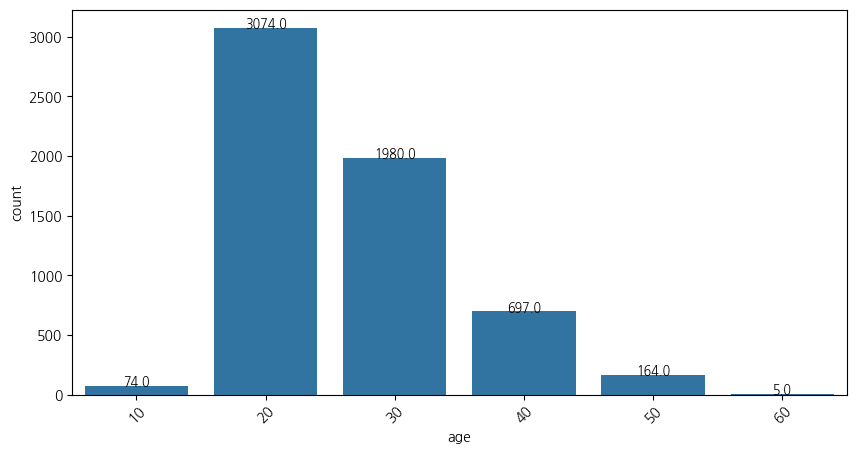

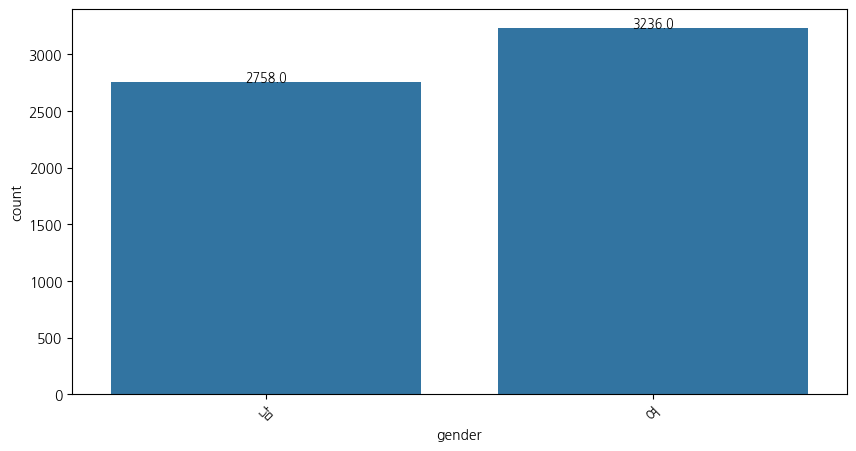

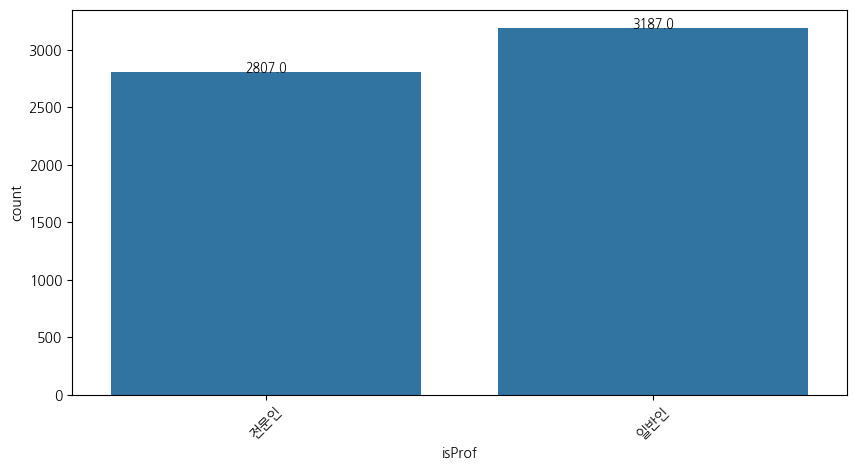

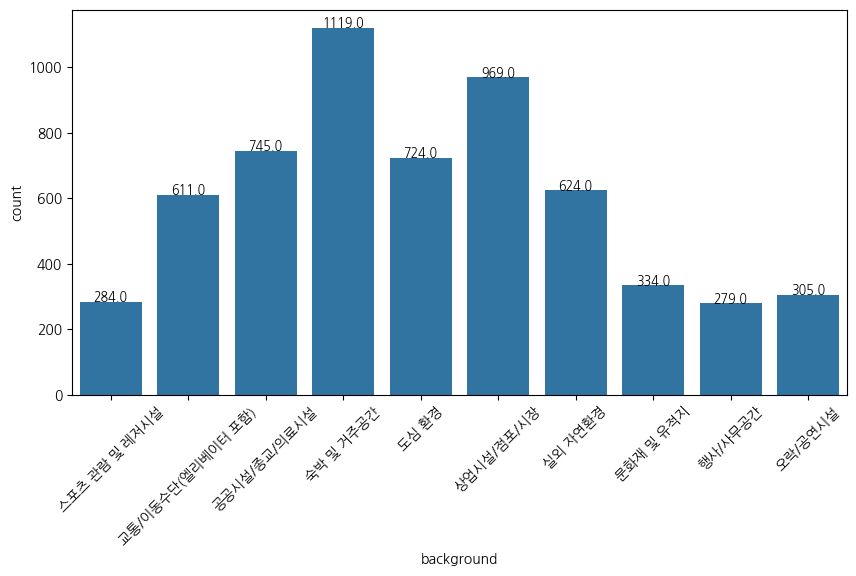

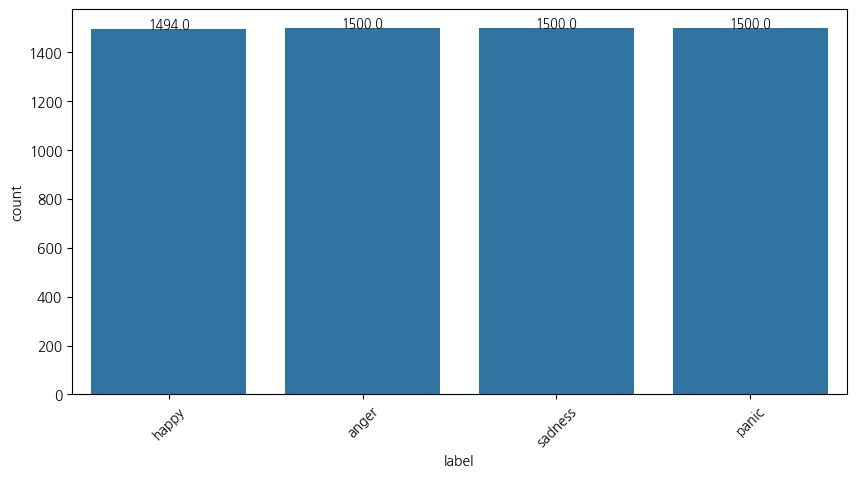

In [ ]:
col_list = ['age', 'gender', 'isProf', 'background', 'label']
for col in col_list:
    plt.figure(figsize=(10, 5))
    ax = sns.countplot(x=train_df[col])
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
    for p in ax.patches:
        height = p.get_height()
        ax.text(p.get_x() + p.get_width() / 2., height + 3, height, ha='center', size=9)
    plt.show()

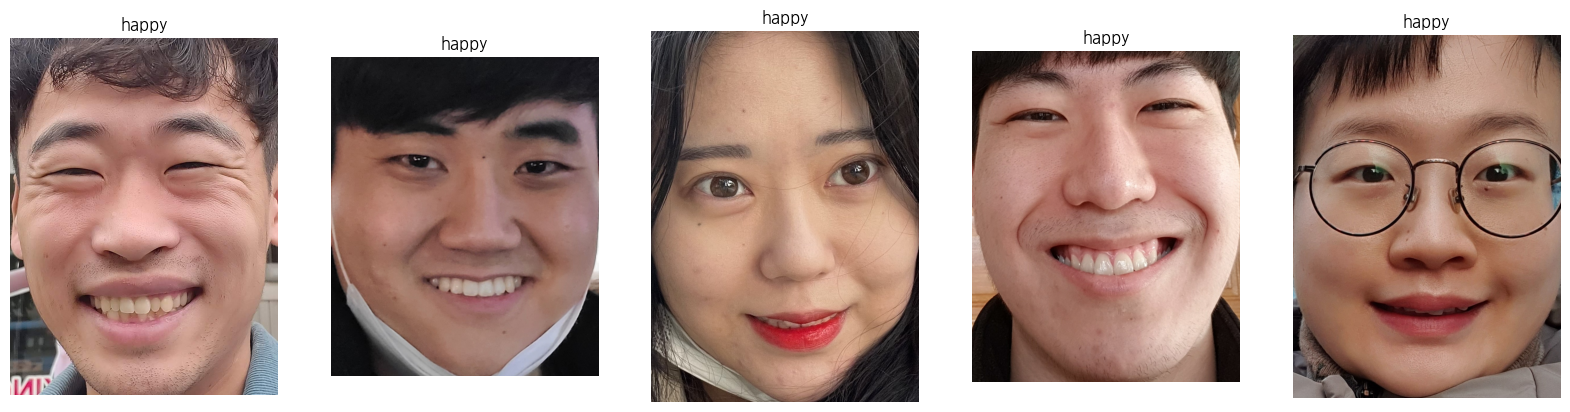

In [ ]:
fig, axs = plt.subplots(nrows=1, ncols=5, figsize=(20, 20))
for i in range(5):
    image_file = train_df.loc[i,'img_path']
    img = cv2.imread(image_file)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    axs[i].imshow(img)
    axs[i].axis('off')
    axs[i].set_title(train_df.loc[i,'label'], size='large')